<a href="https://colab.research.google.com/github/C242-PS253-Capstone-Team/ML_Face_Shape_Recognition/blob/rifal/ML_Model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
pip install --upgrade tensorflow keras

In [ ]:
pip install mtcnn

In [ ]:
pip install lz4

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import cv2
import tensorflow as tf
import keras
import mtcnn

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from keras.utils import plot_model
from matplotlib import pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# EDA

#### Load Dataset

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dr = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_train'
# train_data_2 = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/men_face_dataset'
# dataset_3 = '/content/drive/MyDrive/Dataset Capstone/'
# ....
# dataset_1 = '/content/drive/MyDrive/Dataset Capstone/'

In [4]:
test_dr = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_test'

In [5]:
print("Isi folder training:")
print(os.listdir(train_dr))

print("\nIsi folder testing:")
print(os.listdir(test_dr))

Isi folder training:
['Oblong', 'Heart', 'Square', 'Oval', 'Round']

Isi folder testing:
['Square', 'Heart', 'Oval', 'Round', 'Oblong']


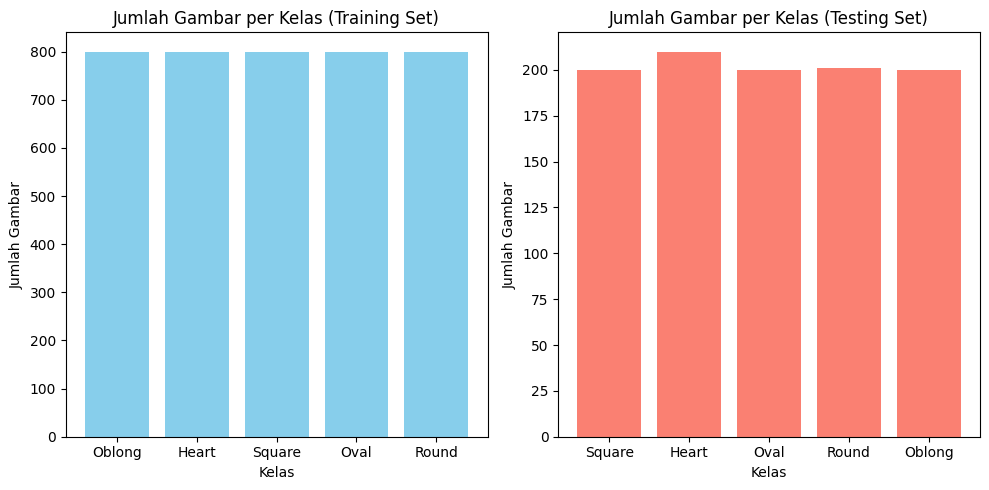

In [6]:
def count_images_in_classes(directory):
    """
    Fungsi untuk menghitung jumlah gambar di setiap kelas dalam direktori.

    Args:
        directory (str): Jalur ke direktori dataset.

    Returns:
        dict: Kamus dengan nama kelas sebagai kunci dan jumlah gambar sebagai nilai.
    """
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Pastikan hanya menghitung folder
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Hitung jumlah gambar untuk masing-masing kelas
train_counts = count_images_in_classes(train_dr)
test_counts = count_images_in_classes(test_dr)

# Plot jumlah data training
plt.figure(figsize=(10, 5))

# Bar chart untuk training set
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Jumlah Gambar per Kelas (Training Set)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')

# Bar chart untuk testing set
plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values(), color='salmon')
plt.title('Jumlah Gambar per Kelas (Testing Set)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')

# Menampilkan plot
plt.tight_layout()
plt.show()

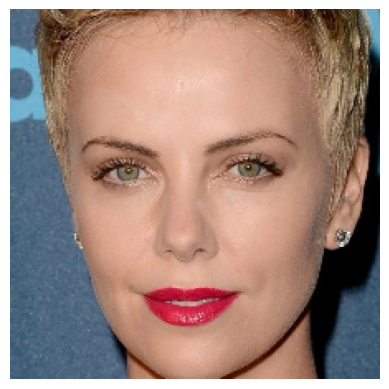

In [30]:
# Inisialisasi detektor MTCNN
detector = MTCNN()

def extract_face(img, target_size=(224,224)):
    '''this function extracts the face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''

    # 1. deteksi wajah pada gambar
    results = detector.detect_faces(img)
    if results == []:  # jika wajah tidak terdeteksi, crop & resize dengan mempertahankan rasio aspek
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = img[y1:y2, x1:x2]  # wajah dari bounding box sebelum ekspansi bbox

        # 2. memperbesar bagian atas dan bawah bounding box sebanyak 10 pixel untuk memastikan seluruh wajah terekstrak
        adj_h = 10
        new_y1 = max(0, y1 - adj_h)
        new_y2 = min(img.shape[0], y1 + height + adj_h)
        new_height = new_y2 - new_y1

        # 3. crop gambar menjadi bentuk persegi
        adj_w = int((new_height - width) / 2)
        new_x1 = max(0, x1 - adj_w)
        new_x2 = min(img.shape[1], x2 + adj_w)
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # crop wajah ke bentuk persegi

    # 4. resize gambar ke ukuran target
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

# Fungsi untuk memuat dan mengekstrak wajah dari file gambar
def extract_face_from_image(image_path):
    img = cv2.imread(image_path)  # Membaca gambar
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Mengubah gambar menjadi RGB
    face = extract_face(img_rgb)  # Memanggil fungsi extract_face untuk mengekstrak wajah
    return face

# Uji dengan gambar tertentu
image_path = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_test/Oval/oval (197).jpg'  # Ganti dengan path gambar yang sesuai
extracted_face = extract_face_from_image(image_path)

# Menampilkan hasil wajah yang telah diekstraksi
if extracted_face is not None:
    plt.imshow(extracted_face)
    plt.axis('off')
    plt.show()
else:
    print("Wajah tidak terdeteksi!")

In [32]:
IMG_SHAPE = (256, 256, 3)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

tuning_layer_name = 'block_13_expand'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# Membekukan semua layer sebelum tuning_layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable = False

# Layer augmentasi
data_augmentation = tf.keras.Sequential([
    Rescaling(1./127.5, offset=-1),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.3),
    RandomTranslation(0.1, 0.1),
], name='data_augmentation')

<ipython-input-32-08c57f5bea34>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [33]:
model = Sequential([
    data_augmentation,
    base_model,
    Conv2D(256, (3, 3), activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(train_counts), activation='softmax')
])

learning_rate = 0.0001
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
